In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
class PipelineLeakDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Populate image paths and labels
        for label, class_dir in enumerate(["Leak", "Non_leak"]):
            class_path = os.path.join(root_dir, class_dir)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization used for pre-trained models
])

In [4]:
# Define the root directory for your dataset
root_dir = "Pipeline_dataset_channel_1"

# Initialize the dataset and dataloader
dataset = PipelineLeakDataset(root_dir=root_dir, transform=transform)

In [5]:
# Define split ratios
train_ratio = 0.8
test_ratio = 0.2

# Calculate split sizes
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [6]:
# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Identity()  # Remove final dense layer
    
    def forward(self, x):
        return self.model(x)

class VisionTransformer(nn.Module):
    def __init__(self):
        super(VisionTransformer, self).__init__()
        self.model = models.vit_b_16(pretrained=True)
        self.model.heads = nn.Identity()  # Remove final dense layer

    def forward(self, x):
        return self.model(x)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Instantiate models
cnn_model = SimpleCNN().to(device)
vit_model = VisionTransformer().to(device)

# Define training functions
def train_model(model, dataloader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

c:\Users\admin\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\admin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-

In [11]:
# Freeze both models
for param in cnn_model.parameters():
    param.requires_grad = False
for param in vit_model.parameters():
    param.requires_grad = False

In [12]:
# Define the parallel model
class ParallelModel(nn.Module):
    def __init__(self, cnn, vit):
        super(ParallelModel, self).__init__()
        self.cnn = cnn
        self.vit = vit
        self.fc = nn.Sequential(
            nn.Linear(512 + 768, 256),  # Adjust based on output size of cnn and vit
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)  # Final classification layer
        )

    def forward(self, x):
        cnn_features = self.cnn(x)
        vit_features = self.vit(x)
        combined_features = torch.cat((cnn_features, vit_features), dim=1)
        return self.fc(combined_features)


feature heat map requeired?


In [13]:
parallel_model = ParallelModel(cnn_model, vit_model).to(device)

In [14]:
def train_parallel_model(model, train_dataloader, validation_dataloader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    
    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Accumulate training loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_dataloader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in validation_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        
        # Calculate average validation loss and accuracy
        val_loss /= len(validation_dataloader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    return train_losses, train_accuracies, val_losses, val_accuracies


In [15]:
# Train the model and get the metrics
train_losses, train_accuracies, val_losses, val_accuracies = train_parallel_model(parallel_model, train_loader, test_loader, num_epochs=20)

Epoch 1/20, Train Loss: 0.5413, Train Accuracy: 71.88%, Validation Loss: 0.4484, Validation Accuracy: 88.89%
Epoch 2/20, Train Loss: 0.3395, Train Accuracy: 90.62%, Validation Loss: 0.3485, Validation Accuracy: 98.61%
Epoch 3/20, Train Loss: 0.2349, Train Accuracy: 95.83%, Validation Loss: 0.2130, Validation Accuracy: 98.61%
Epoch 4/20, Train Loss: 0.1792, Train Accuracy: 97.57%, Validation Loss: 0.1338, Validation Accuracy: 100.00%
Epoch 5/20, Train Loss: 0.1181, Train Accuracy: 98.26%, Validation Loss: 0.0848, Validation Accuracy: 100.00%
Epoch 6/20, Train Loss: 0.0977, Train Accuracy: 99.31%, Validation Loss: 0.0685, Validation Accuracy: 100.00%
Epoch 7/20, Train Loss: 0.0825, Train Accuracy: 98.96%, Validation Loss: 0.0491, Validation Accuracy: 100.00%
Epoch 8/20, Train Loss: 0.0656, Train Accuracy: 99.31%, Validation Loss: 0.0400, Validation Accuracy: 100.00%
Epoch 9/20, Train Loss: 0.0524, Train Accuracy: 99.31%, Validation Loss: 0.0332, Validation Accuracy: 100.00%
Epoch 10/20, 

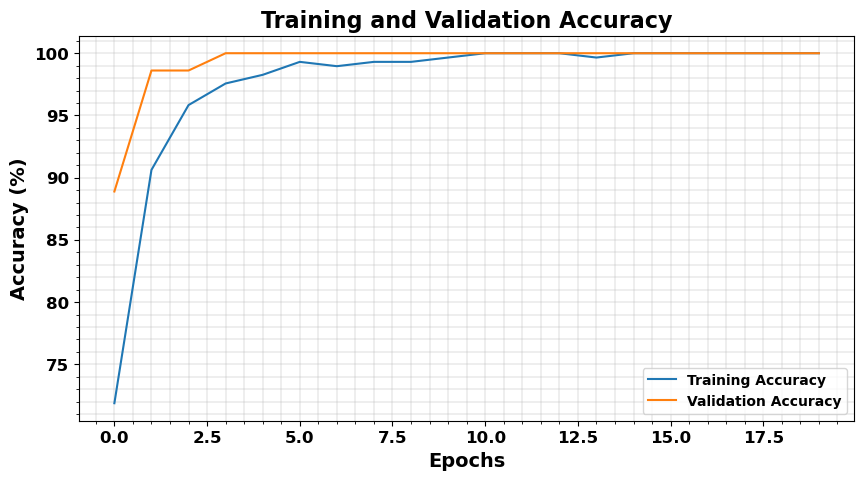

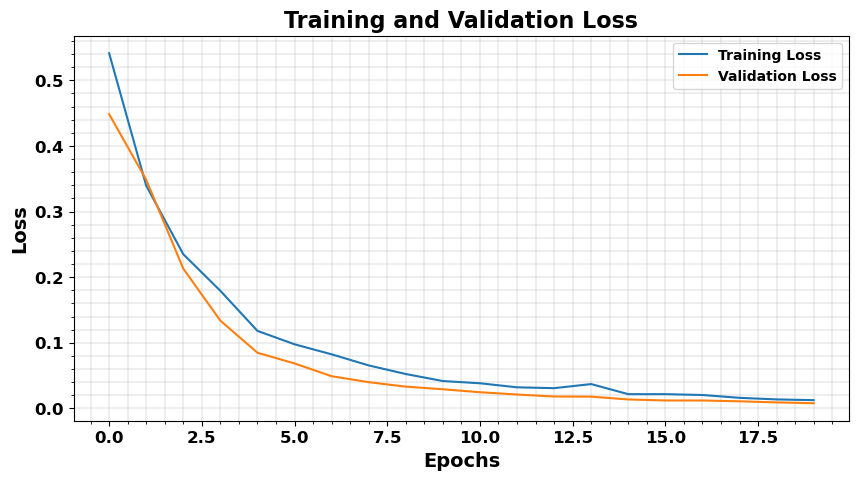

In [16]:

# Plotting the accuracy curves with customized formatting
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

# Adding labels, title, and legend with larger and bold font
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, prop={'weight':'bold'})

# Make tick labels bold and increase font size
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding a grid with both major and minor grid lines
plt.grid(True, which='both', linewidth=0.3)
plt.minorticks_on()
plt.savefig("Proposed_model_training_val_accuracy.png", dpi=400)
plt.show()

# Plotting the loss curves with customized formatting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Adding labels, title, and legend with larger and bold font
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, prop={'weight':'bold'})

# Make tick labels bold and increase font size
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding a grid with both major and minor grid lines
plt.grid(True, which='both', linewidth=0.3)
plt.minorticks_on()
plt.savefig("Proposed_model_training_val_loss.png", dpi=400)
plt.show()

In [ ]:
# Specify the file path to save the model
model_save_path = "parallel_model.pth"

# Save the model's state_dict (recommended method)
# torch.save(parallel_model.state_dict(), model_save_path)

In [18]:
# Initialize the model structure first
parallel_model = ParallelModel(cnn_model, vit_model).to(device)  # Replace with the correct model initialization if necessary

# Load the saved state_dict
parallel_model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode (optional, but recommended for inference)
parallel_model.eval()

ParallelModel(
  (cnn): SimpleCNN(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNo

In [19]:
from sklearn.metrics import classification_report

In [20]:
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Calculate and print classification report for per-class metrics
    report = classification_report(all_labels, all_predictions, target_names=["No Leak", "Leak"], output_dict=True)
    
    # Extract overall metrics
    overall_accuracy = report['accuracy'] * 100
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    # Print overall metrics
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"Weighted Precision: {precision:.2f}")
    print(f"Weighted Recall: {recall:.2f}")
    print(f"Weighted F1 Score: {f1:.2f}")
    
    # Print per-class metrics
    print("\nPer-Class Metrics:")
    for class_name, metrics in report.items():
        if class_name in ["No Leak", "Leak"]:
            print(f"\nClass '{class_name}':")
            print(f"  Precision: {metrics['precision']:.2f}")
            print(f"  Recall: {metrics['recall']:.2f}")
            print(f"  F1 Score: {metrics['f1-score']:.2f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Leak", "Leak"], yticklabels=["No Leak", "Leak"], cbar=False, 
                annot_kws={"size": 20, "fontweight": "bold"})  # Set annotation font size and bold


    # Increase font size for axis labels and title
    plt.xlabel('Predicted Label ', fontsize=16, fontweight = 'bold')
    plt.ylabel('True Label', fontsize=16, fontweight = 'bold')

    # Additional step: Use plt.setp() to make tick labels bold
    plt.setp(plt.gca().get_xticklabels(), fontweight='bold')  # Set x-tick labels to bold
    plt.setp(plt.gca().get_yticklabels(), fontweight='bold')  # Set y-tick labels to bold

    # Increase tick label font size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Save the figure with 400 DPI
    plt.savefig("confusion_matrix.png", dpi=1000)

    plt.show()

Overall Accuracy: 100.00%
Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1 Score: 1.00

Per-Class Metrics:

Class 'No Leak':
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00

Class 'Leak':
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00


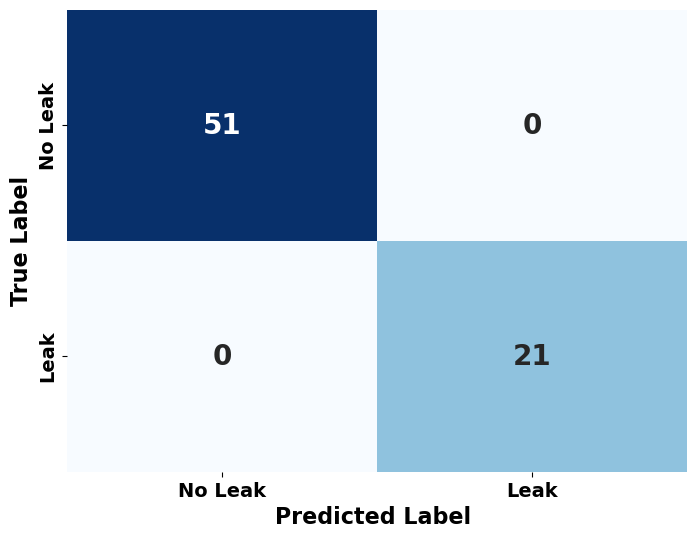

In [21]:
evaluate_model(parallel_model, test_loader)

c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


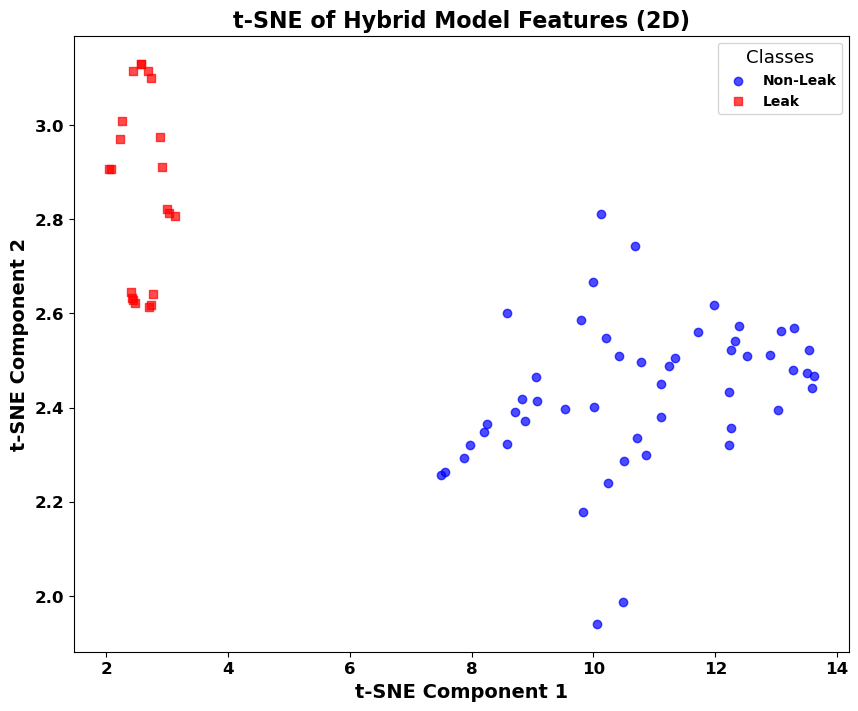

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np

# Set the model to evaluation mode
parallel_model.eval()

# Define the layer name in your hybrid model from which to extract features
layer_name = 'dense_3'  # Replace with the actual layer name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
parallel_model.to(device)

def get_features(model, layer_name, data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            if isinstance(data, (list, tuple)):
                data = [d.to(device) for d in data]  # Assuming multiple inputs
                output = model(*data)
            else:
                data = data.to(device)
                output = model(data)
                
            # Extract features from the specified layer; adjust if necessary
            feature = output.cpu().numpy()  # This assumes `output` is already the layer output; adjust if needed
            features.append(feature)
            labels.append(label.cpu().numpy())
    
    return np.concatenate(features), np.concatenate(labels)

# Assuming you have a DataLoader for test data
features, labels_val = get_features(parallel_model, layer_name, test_loader)

# Reshape features for t-SNE
features_val = features.reshape(features.shape[0], -1)

# Apply t-SNE to the features (2D version)
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_val)

# Plot the result of t-SNE in 2D for "Leak" and "Non-Leak" classes
plt.figure(figsize=(10, 8))

# Define markers and colors for two classes
class_names = ["Non-Leak", "Leak"]
markers = ['o', 's']  # Circle for Non-Leak, Square for Leak
colors = ['blue', 'red']

# Loop over each class and plot with specific markers and colors
for class_idx, (class_name, marker, color) in enumerate(zip(class_names, markers, colors)):
    class_mask = (labels_val == class_idx)  # Mask for the current class
    plt.scatter(features_tsne[class_mask, 0], features_tsne[class_mask, 1], 
                marker=marker, color=color, label=class_name, alpha=0.7)

# Add legend
plt.legend(title="Classes", loc='upper right', prop={'weight': 'bold'}, fontsize=12, title_fontsize='13')

# Add title and labels
plt.title('t-SNE of Hybrid Model Features (2D)', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=14, fontweight='bold')

# Make the axis tick labels bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Save the figure
plt.savefig('tsne_2d_hybrid_model_leak_non_leak.png', dpi=1000)

# Show the plot
plt.show()